In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

In [2]:
data = pd.read_csv('D:/深度学习与信息论/creditcard.csv')

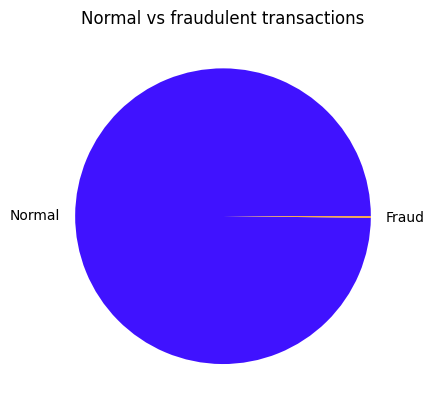

In [3]:
orange, purple = '#ffa022', '#4012ff'
fig, ax = plt.subplots()
ax.pie(data.groupby(['Class']).Class.count(), labels= ['Normal', 'Fraud'], colors=[purple, orange])
plt.title('Normal vs fraudulent transactions')
plt.show()

In [5]:
# Take a random sample of 1000 normal transactions and all fraud transactions
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

# Shuffle fraud and non_fraud samples and separate into features and labels
# Concatenate fraud and non_fraud samples
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

# Separate into features and labels
X = df.drop(['Class'], axis=1).values
y = df["Class"].values

In [8]:
def tsne_plot(X, y, name, title='TSNE plot of Fraud and Non Fraud'):
    tsne = TSNE(n_components=2, random_state=24, init='random', learning_rate=200)
    X_t = tsne.fit_transform(X)

    plt.figure(figsize=(12,8))
    plt.scatter(X_t[np.where(y==0), 0], X_t[np.where(y==0), 1], color='darkorange', alpha = 0.7, label = "Non Fraud")
    plt.scatter(X_t[np.where(y==1), 0], X_t[np.where(y==1), 1], color='mediumblue', alpha = 0.7, label = "Fraud")

    plt.legend(loc='best')
    plt.title(title, fontsize=16)
    #experiment.log_figure(figure=plt)
    plt.savefig(name)
    plt.show()

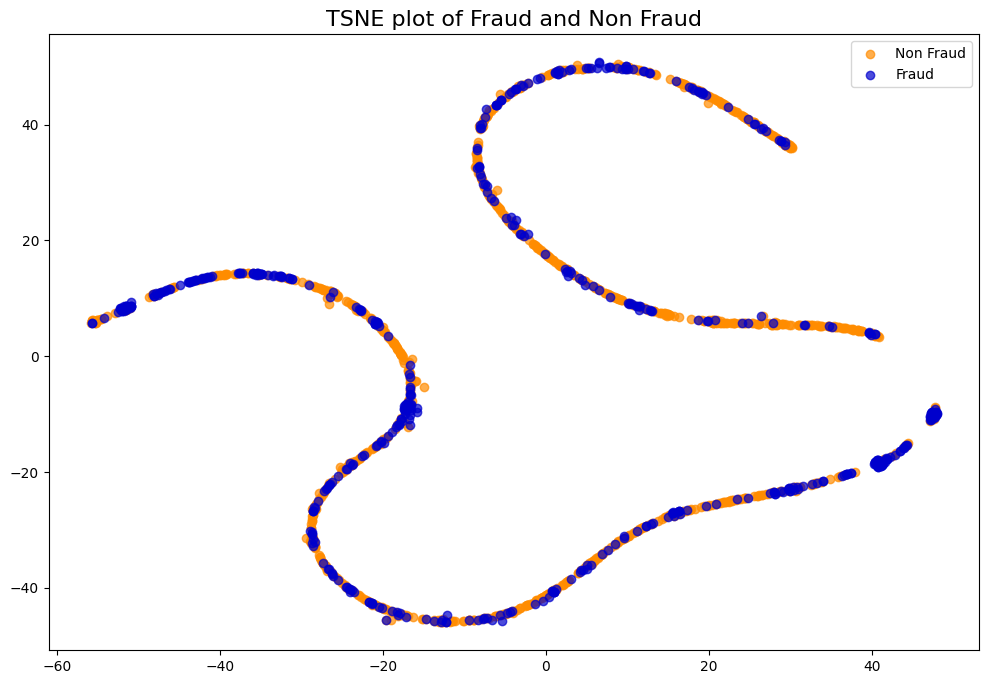

In [9]:
tsne_plot(X, y, name="original.png")

In [10]:
# Convert relative 'Time' measure to hour of day
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

# Scale 'Time' and 'Amount'
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))

# Separate fraudulent transactions from normal transactions
norm_data, fraud_data = data[data['Class']==0], data[data['Class']==1]

# Training data will be 2000 normal samples
# Validation data will be 1000 samples, approximately half fraud and half normal samples; shuffled and with indices reset
# We leave out 200 normal samples and 50 fraud samples for a final test dataset of 250 unseen samples; we'll choose a random subsample of these later
train_data = norm_data.iloc[:2000, :]
val_data = pd.concat([norm_data.iloc[2000:2558,:], fraud_data.iloc[:442, :]], axis =0).sample(frac=1).reset_index(drop=True)
test_samples = pd.concat([norm_data.iloc[2558:2608,:], fraud_data.iloc[442:,:]], axis=0).sample(frac=1).reset_index(drop=True)

In [11]:
# These hyperparameters will be logged
hyper_params = {
    "learning_rate": 1e-1/10,
    "epochs": 150,
    "batch_size": 32,
    "weight_decay": 1e-8,
    'threshold': 0.75
}

In [12]:
# Create pytorch data loader for training set
train_target = torch.tensor(train_data['Class'].values.astype(np.float32))
train = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = hyper_params['batch_size'], shuffle = True)

# Create pytorch data loader for validation set
val_target = torch.tensor(val_data['Class'].values.astype(np.float32))
val = torch.tensor(val_data.drop('Class', axis = 1).values.astype(np.float32))
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = 1, shuffle = True)

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30,14),
            nn.Tanh(),
            nn.Linear(14,7),
            nn.Tanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.Tanh(),
            nn.Linear(14,30),
            nn.Tanh()
            )
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=hyper_params["learning_rate"], 
                             weight_decay=hyper_params['weight_decay'])

In [15]:
for epoch in range(hyper_params['epochs']):
    losses = []
    for (data, _) in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)     
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    # ===================log========================

    losses = []
    labels = []
    preds = []
    embeds = []
    
    for data, label in val_loader:
        # ===================forward=====================
        reconstructed = model(data)
        loss = torch.sigmoid(criterion(reconstructed, data)).item()
        losses.append(round((loss),6))
        labels.append(label.item())
        preds.append(reconstructed[0][-1].item())
        embeds.append(reconstructed[0][:-1].detach().cpu().numpy())

    # ===================log========================  

    if epoch == (hyper_params["epochs"] - 1):
        print("logging table")
        df = pd.DataFrame()
        df['Reconstruction_Loss'] = losses
        df['Labels_gt'] = labels
        df['Labels_preds']= [int(x >= hyper_params['threshold']) for x in losses]
print('complete')

logging table
complete


In [16]:
def plot_precision_recall_curves(df):
    # Calculate precision and recall 
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    # Plot recall precision tradeoff
    sns.set(style="white")
    plt.figure(figsize=(8,6))
    plt.step(recall, precision, color= purple, alpha=0.4, where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color=purple)
    plt.title('Recall vs Precision', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.savefig('precision_recall_curve_x.png')
    print(plt.show())

    # Plot precision and recall for different thresholds
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precision[1:], label="Precision",color= orange, linewidth=2.5)
    plt.plot(thresholds, recall[1:], label="Recall",color= purple, alpha=0.9,linewidth=2.5)
    plt.title('Precision and recall for different threshold values', fontsize=16)
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    
    #plt.savefig('threshold_values_x.png')
    plt.show()

In [17]:
def reconstruction_error_plot(df, ylims = (None, None), title="Reconstruction error for different classes"):  
    groups = df.groupby('Labels_gt')
    sns.set(style="white")
    sns.set_palette(sns.color_palette([orange, purple]))
    fig, ax = plt.subplots(figsize=(8,6)) 

    for name, group in groups:
        ax.plot(group.index, 
            group.Reconstruction_Loss, 
            marker='o', 
            ms=5, 
            linestyle='',
            label= "Fraud" if name == 1 else "Nonfraud")
    
    ax.hlines(hyper_params['threshold'], 
            ax.get_xlim()[0], 
            ax.get_xlim()[1], 
            colors="r", 
            zorder=100, 
            label='Threshold',
            linestyle='--')
    ax.legend()
    plt.title(title, fontsize=16)
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.ylim(top=ylims[0], bottom=ylims[1])
    plt.legend(loc='best')
    #plt.savefig('reconstruction_error_plot_x.png')
    plt.show()

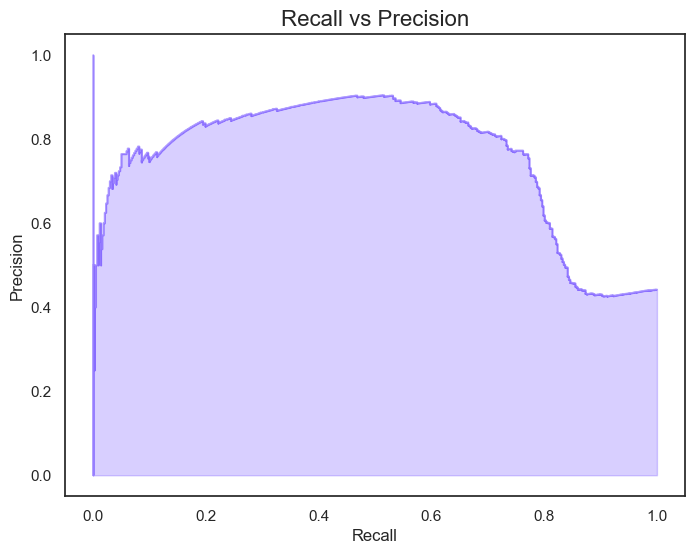

None


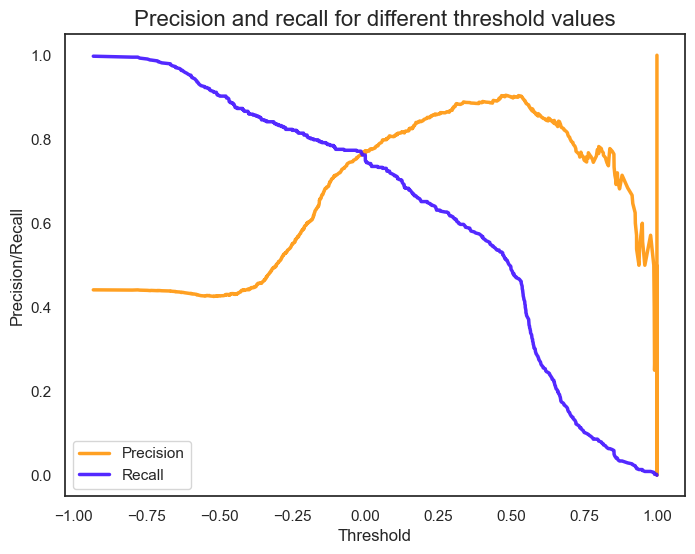

In [18]:
plot_precision_recall_curves(df)

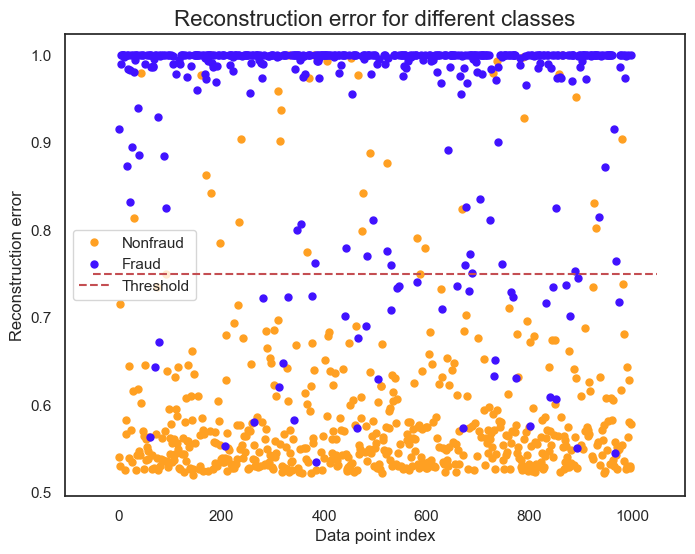

In [19]:
reconstruction_error_plot(df)

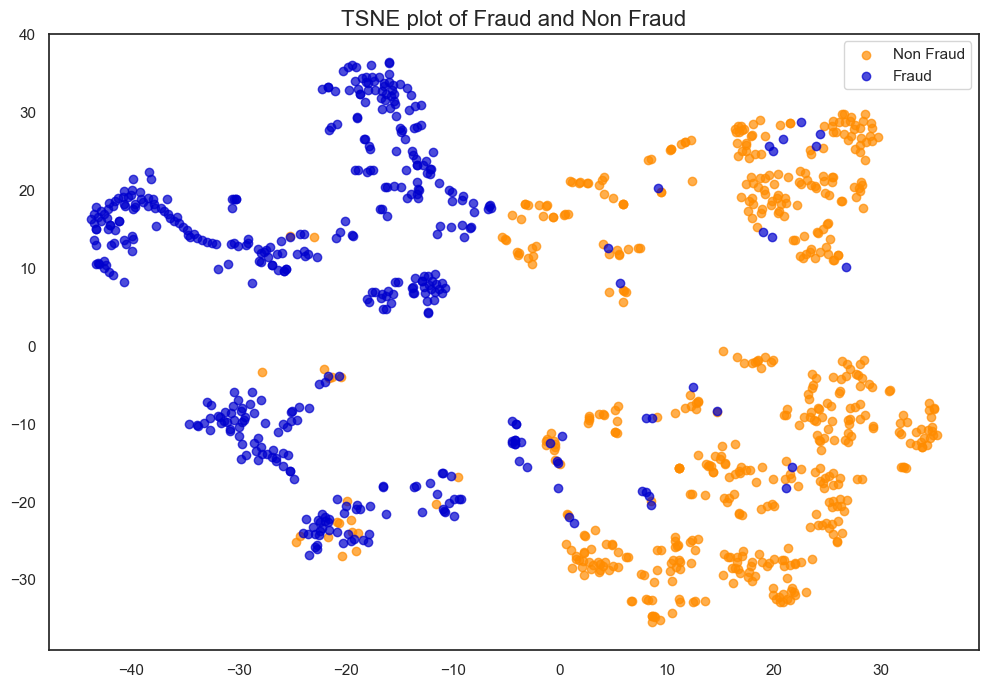

In [20]:
X = np.array(embeds)
y=df['Labels_gt'].values
tsne_plot(X, y, name='latent_rep.png')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

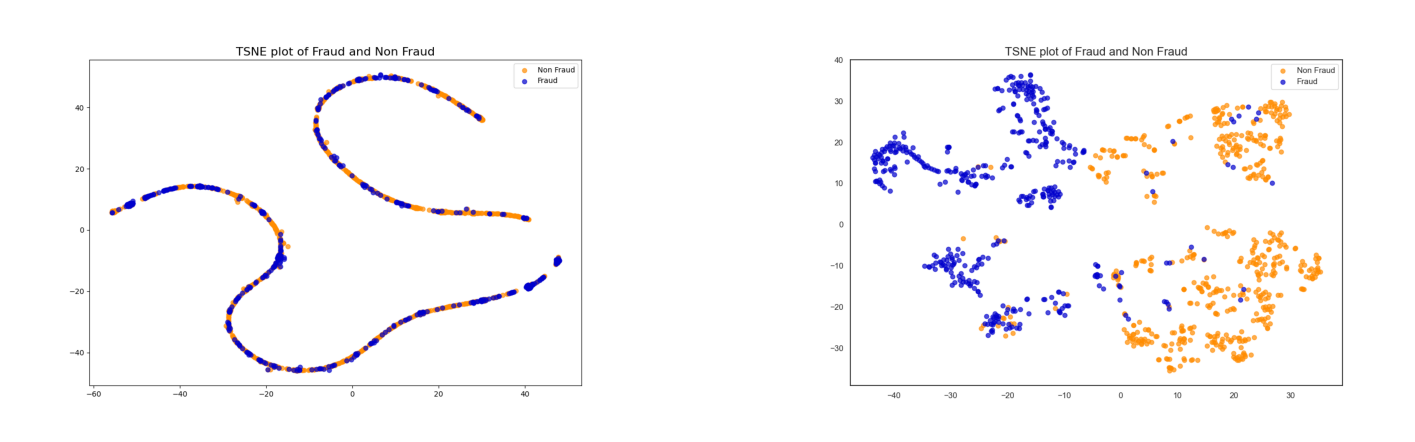

In [21]:
sns.set(style="white")
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)
plt.imshow(img.imread('original.png'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.imread('latent_rep.png'))
plt.axis('off')

plt.tight_layout

In [22]:
print("Classification report \n {0}".format(classification_report(df.Labels_gt, df.Labels_preds)))

Classification report 
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       558
         1.0       0.92      0.91      0.91       442

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

